## Imports

In [1]:
from __future__ import annotations

import math
from typing import Literal

from PIL import Image
import sklearn
import torch; from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# pytorch with gpu
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("GPU is available and being used")
else:
    DEVICE = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


## Non-Linearity
Many real-life problems aren't able to be defined by linear regression and often have many dimensions with many correlated variables, a non-linear problem. We use different activation functions within a neural network to introduce non-linearity into our network:
- Rectified Linear Unit (ReLU)
- Sigmoid
- Hyperbolic Tangent (tanh)

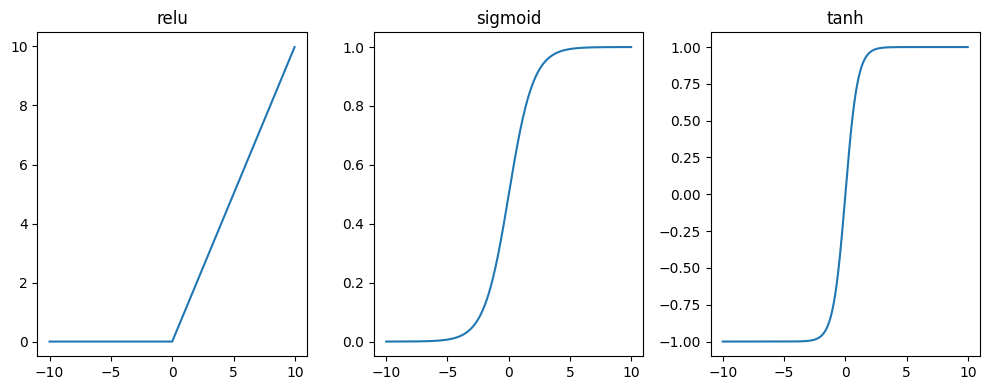

In [2]:
relu = lambda x: x if x > 0 else 0
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: math.tanh(x)
values = np.arange(-10, 10, 0.02)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(10, 4)

axes.flat[0].set_title('relu')
axes.flat[0].plot(values, [relu(x) for x in values])

axes.flat[1].set_title('sigmoid')
axes.flat[1].plot(values, [sigmoid(x) for x in values])

axes.flat[2].set_title('tanh')
axes.flat[2].plot(values, [tanh(x) for x in values])

plt.tight_layout()

## Load `Multi-Class` Dataset

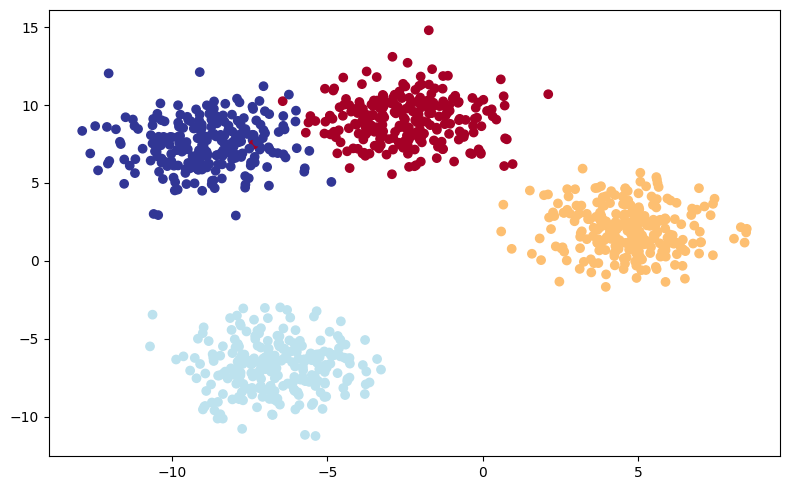

In [111]:
N_SAMPLES = 1000
N_CLASSES = 4
N_FEATURES = 2
RANDOM_STATE = 42

# create a toy tensor multiclass dataset
X, y = make_blobs(n_samples=N_SAMPLES, 
                  n_features=N_FEATURES,
                  centers=N_CLASSES,
                  cluster_std=1.5,
                  random_state=RANDOM_STATE)

# tensorify data
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# visualize data
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.tight_layout()

## Build `Multi-Class` Classification Model

In [112]:
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

class BlobModelV0(nn.Module):
    _torch_dict = torch.__dict__

    def __init__(self, *, input_features: int, hidden_layers: list[int], activations: list[str], output_features: int, device: Literal['cpu', 'cuda'] | torch.cuda.device = 'cpu') -> None:
        super().__init__()

        # basic init
        self._hidden_count = len(hidden_layers)
        self._loss_fn: nn.modules.loss._Loss = None
        self._optimizer: torch.optim.Optimizer = None

        # check that activations match hidden units len
        if len(activations) != len(hidden_layers):
            raise ValueError(f'Parameter "activations" should have the same length as parameter "hidden_units", got lengths {len(activations)} and {len(hidden_layers)} instead.')

        # convert str activations to methods
        self._activations = []
        for act in activations:
            self._activations.append(self._torch_dict[act])

        # dynamically create layers
        self.input = nn.Linear(in_features=input_features, out_features=hidden_layers[0])
        for i, units in enumerate(hidden_layers[:-1]):
            setattr(self, f'hidden_{i}', nn.Linear(in_features=units, out_features=hidden_layers[i - 1]))
        self.output = nn.Linear(in_features=hidden_layers[-1], out_features=output_features)

        # use passed device, default to cpu
        self = self.to(device)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # pass to input
        z = self._activations[0](self.input(X))

        # pass to hidden
        for i in range(self._hidden_count - 1):
            z = self._activations[i + 1](getattr(self, f'hidden_{i}')(z))

        # pass to output and return
        return torch.softmax(self.output(z), dim=1)
    
    def compile(self, loss_fn: nn.modules.loss._Loss, optimizer: torch.optim.Optimizer) -> BlobModelV0:
        self._loss_fn = loss_fn
        self._optimizer = optimizer
        return self

    def fit(self, X: torch.Tensor, y: torch.Tensor, epochs: int, evaluation: tuple[torch.Tensor, torch.Tensor] = None) -> None:
        # iterate over epochs
        for epoch in range(epochs):
            self.train(True)

            # get prediction
            y_logits = self(X)
            y_pred = torch.argmax(y_logits, 1)

            # calculate loss and accuracy
            loss = self._loss_fn(y_logits, y.type(torch.int64))
            acc = torch.eq(y_pred, y).sum().item() / len(y) * 100

            # backpropagation & gradient descent
            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()

            # if evaluation set passed
            if epoch % 50 == 0:
                self.eval()
                with torch.inference_mode():
                    if evaluation is not None:
                        # get prediction logits
                        test_logits = self(evaluation[0])
                        test_pred = torch.argmax(test_logits, 1)

                        # calculate loss and accuracy
                        test_loss = self._loss_fn(test_logits, evaluation[1].type(torch.int64)).item()
                        test_acc = torch.eq(test_pred, evaluation[1]).sum().item() / len(y_test) * 100

                    # print info
                    print(f'| Epoch {epoch:0>{len(str(epochs))}} | Acc: {acc:.3f}, Loss: {loss:.3f} | ', end='')
                    if evaluation is not None:
                        print(f'Test Acc: {test_acc:.3f}, Test Loss: {test_loss:.3f} |')
                    else:
                        print()

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        return torch.argmax(self(X), dim=1).cpu().numpy()
     

In [144]:
# build and compile model
model = BlobModelV0(input_features=2,
                    hidden_layers=[8, 8],
                    activations=['relu', 'relu'],
                    output_features=4,
                    device=DEVICE)
model.compile(nn.CrossEntropyLoss(),    
              torch.optim.SGD(model.parameters(), 0.03))

# fit model to data
model.fit(X_train, y_train, 901, evaluation=(X_test, y_test))

| Epoch 000 | Acc: 22.625, Loss: 1.402 | Test Acc: 27.500, Test Loss: 1.385 |
| Epoch 050 | Acc: 59.000, Loss: 1.264 | Test Acc: 65.500, Test Loss: 1.238 |
| Epoch 100 | Acc: 54.500, Loss: 1.113 | Test Acc: 63.000, Test Loss: 1.085 |
| Epoch 150 | Acc: 98.125, Loss: 1.001 | Test Acc: 99.000, Test Loss: 0.976 |
| Epoch 200 | Acc: 99.250, Loss: 0.900 | Test Acc: 99.000, Test Loss: 0.878 |
| Epoch 250 | Acc: 99.375, Loss: 0.825 | Test Acc: 99.500, Test Loss: 0.813 |
| Epoch 300 | Acc: 99.375, Loss: 0.791 | Test Acc: 99.500, Test Loss: 0.784 |
| Epoch 350 | Acc: 99.375, Loss: 0.777 | Test Acc: 99.500, Test Loss: 0.772 |
| Epoch 400 | Acc: 99.375, Loss: 0.770 | Test Acc: 99.500, Test Loss: 0.765 |
| Epoch 450 | Acc: 99.375, Loss: 0.766 | Test Acc: 99.500, Test Loss: 0.762 |
| Epoch 500 | Acc: 99.375, Loss: 0.764 | Test Acc: 99.500, Test Loss: 0.760 |
| Epoch 550 | Acc: 99.375, Loss: 0.762 | Test Acc: 99.500, Test Loss: 0.758 |
| Epoch 600 | Acc: 99.375, Loss: 0.761 | Test Acc: 99.500, Test 

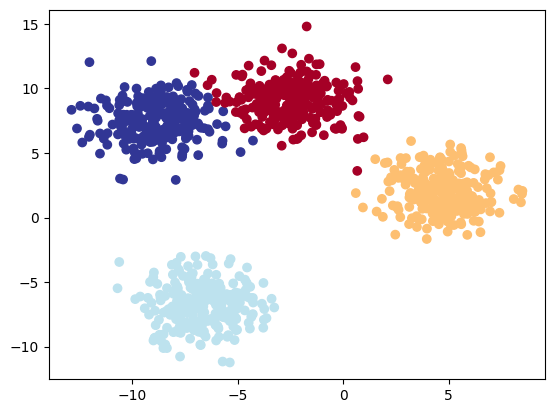

In [114]:
y_pred = model.predict(X_test)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_pred, cmap=plt.cm.RdYlBu)

y_pred = model.predict(X_train)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_pred, cmap=plt.cm.RdYlBu)